**Bias in AI-Based Traffic Ticketing: Analyzing Disproportionate Impacts on Racial Groups and Demographic Disparities**

**LOS ANGELES**

**Step 1: Load the Dataset and Preprocess the Data**

In [ ]:
import pandas as pd
import zipfile
import os


# Define paths
zip_path = '/content/yg821jf8611_ca_los_angeles_2020_04_01.csv.zip'
extract_path = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files to confirm the CSV file name
print("Extracted files:", os.listdir(extract_path))

# Set the CSV file path (using the correct file name)
csv_file = os.path.join(extract_path, 'ca_los_angeles_2020_04_01.csv')

# Load CSV into a DataFrame
df = pd.read_csv(csv_file)

# Display the first few rows
df.head()

Extracted files: ['.config', 'ca_los_angeles_2020_04_01.csv', 'yg821jf8611_ca_los_angeles_2020_04_01.csv.zip', 'processed_data.csv', 'sample_data']


<ipython-input-18-eab878e1db3d>:21: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


,raw_row_number,date,time,district,region,subject_race,subject_sex,officer_id_hash,type,raw_descent_description
0,5692933,NaN,13:59:00,0753,WILSHIRE,hispanic,male,15ecd81b00,pedestrian,HISPANIC
1,240731,2010-01-01,00:05:00,665,WEST TRAFFIC,other,male,b707de41e0,vehicular,OTHER
2,240592|240593,2010-01-01,00:10:00,1258,SEVENTY-SEVENTH,hispanic,male,b49ae7078c,pedestrian,HISPANIC
3,241116,2010-01-01,00:10:00,1635,FOOTHILL,hispanic,male,e70ce46248,vehicular,HISPANIC
4,240681,2010-01-01,00:15:00,882,WEST LA,other,male,8587bd743c,vehicular,OTHER


In [ ]:
# Print the size of the DataFrame (number of rows and columns)
print("DataFrame shape:", df.shape)

# List all feature names (columns)
print("\nFeatures:")
print(df.columns.tolist())

# Display data types for each feature
print("\nData Types:")
print(df.dtypes)

# Check for missing values in each column
print("\nMissing Values (per column):")
print(df.isnull().sum())

DataFrame shape: (5418402, 10)

Features:
['raw_row_number', 'date', 'time', 'district', 'region', 'subject_race', 'subject_sex', 'officer_id_hash', 'type', 'raw_descent_description']

Data Types:
raw_row_number             object
date                       object
time                       object
district                   object
region                     object
subject_race               object
subject_sex                object
officer_id_hash            object
type                       object
raw_descent_description    object
dtype: object

Missing Values (per column):
raw_row_number                0
date                          2
time                          0
district                      0
region                     1911
subject_race                  0
subject_sex                   0
officer_id_hash             161
type                          1
raw_descent_description       0
dtype: int64


In [ ]:
# Missing Date values- Drop
# Missing Region- Region may be relevant to bias patterns, so imputing helps retain data.
# officer_id_hash- Choose to retain, key information
# For bias analysis, missing values are often meaningful. Keeping "Unknown" helps ensure fairness, transparency, and completeness.

# Convert 'date' column to datetime format safely
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Convert time column to a time object (if the format is HH:MM:SS)
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.time

# Convert raw_row_number to numeric (if appropriate)
df['raw_row_number'] = pd.to_numeric(df['raw_row_number'], errors='coerce')

#  Convert 'district' column to numeric (fix TypeError issue)
df['district'] = pd.to_numeric(df['district'], errors='coerce')

# Convert region, subject_race, subject_sex, type, and raw_descent_description to categorical types
df['region'] = df['region'].astype('category')
df['subject_race'] = df['subject_race'].astype('category')
df['subject_sex'] = df['subject_sex'].astype('category')
df['type'] = df['type'].astype('category')
df['raw_descent_description'] = df['raw_descent_description'].astype('category')

# Optionally, check the new data types:
print(df.dtypes)

raw_row_number                    float64
date                       datetime64[ns]
time                               object
district                          float64
region                           category
subject_race                     category
subject_sex                      category
officer_id_hash                    object
type                             category
raw_descent_description          category
dtype: object


In [ ]:
import pandas as pd

# ✅ Check for missing values before handling
print("\n🔍 Missing Values Before Handling:")
print(df.isnull().sum())

# 🚨 Drop rows with very few missing values ('date' and 'type')
df = df.dropna(subset=['date', 'type'])

# 🚨 Handle categorical missing values
# If 'region' is categorical, explicitly add "Unknown" as a category before filling NaNs
if df['region'].dtype.name == 'category':
    df['region'] = df['region'].cat.add_categories("Unknown")
df['region'].fillna("Unknown", inplace=True)

# Similarly, handle 'officer_id_hash'
df['officer_id_hash'].fillna("Unknown", inplace=True)

# ✅ Fill missing values for numeric columns with the median
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# ✅ Verify missing values are handled
print("\n✅ Missing Values After Handling:")
print(df.isnull().sum())

# ✅ Display summary statistics
print("\n📊 Summary Statistics:")
print(df.describe())

# ✅ Display first 5 rows to confirm data integrity
print("\n📝 First 5 Rows:")
print(df.head())

# ✅ Step 3: Convert Categorical Data to Lowercase & Standardize Formats
# List the categorical columns
categorical_cols = ['subject_race', 'subject_sex', 'region', 'raw_descent_description', 'type']

# Convert text columns to lowercase for consistency
df[categorical_cols] = df[categorical_cols].astype(str).apply(lambda x: x.str.lower())

# Standardize 'subject_sex' to only have 'male', 'female', or 'unknown'
df['subject_sex'] = df['subject_sex'].apply(lambda x: x if x in ['male', 'female'] else 'unknown')

# ✅ Final check for cleaned data
print("\n📝 Final Processed Data:")
print(df.head())


🔍 Missing Values Before Handling:
raw_row_number             677785
date                            2
time                            0
district                       93
region                       1911
subject_race                    0
subject_sex                     0
officer_id_hash               161
type                            1
raw_descent_description         0
dtype: int64


<ipython-input-22-5f23e9cab855>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'] = df['region'].cat.add_categories("Unknown")
<ipython-input-22-5f23e9cab855>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'].fillna("Unknown", inplace=True)



✅ Missing Values After Handling:
raw_row_number             0
date                       0
time                       0
district                   0
region                     0
subject_race               0
subject_sex                0
officer_id_hash            0
type                       0
raw_descent_description    0
dtype: int64

📊 Summary Statistics:
       raw_row_number                           date      district
count    5.418399e+06                        5418399  5.418399e+06
mean     3.207539e+06  2014-02-18 08:06:37.142844928  1.153853e+03
min      1.000000e+00            2010-01-01 00:00:00  1.000000e+00
25%      1.810458e+06            2012-02-22 00:00:00  6.360000e+02
50%      3.187016e+06            2013-12-04 00:00:00  1.141000e+03
75%      4.596066e+06            2016-02-22 00:00:00  1.636000e+03
max      6.510269e+06            2018-06-23 00:00:00  9.999000e+03
std      1.762440e+06                            NaN  8.429159e+02

📝 First 5 Rows:
   raw_row_number   

In [ ]:
# Step 4: Feature Engineering
# Extract year, month, and hour from the date and time columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.hour

# Create a binary column for nighttime stops (7 PM - 6 AM)
df['is_night'] = df['hour'].apply(lambda x: 1 if (x >= 19 or x <= 6) else 0)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
encoder = LabelEncoder()

# Encode categorical columns but keep the original ones
df['subject_race_encoded'] = encoder.fit_transform(df['subject_race'])
df['subject_sex_encoded'] = encoder.fit_transform(df['subject_sex'])
df['type_encoded'] = encoder.fit_transform(df['type'])

# One-hot encoding for categorical features (region, raw_descent_description)
df = pd.get_dummies(df, columns=['region', 'raw_descent_description'], drop_first=True)


# Check the result
print(df.head())


   raw_row_number       date      time  district subject_race subject_sex  \
1        240731.0 2010-01-01  00:05:00     665.0        other        male   
2       3187015.5 2010-01-01  00:10:00    1258.0     hispanic        male   
3        241116.0 2010-01-01  00:10:00    1635.0     hispanic        male   
4        240681.0 2010-01-01  00:15:00     882.0        other        male   
5        240602.0 2010-01-01  00:20:00     559.0     hispanic        male   

  officer_id_hash        type  year  month  ...  region_west bureau  \
1      b707de41e0   vehicular  2010      1  ...               False   
2      b49ae7078c  pedestrian  2010      1  ...               False   
3      e70ce46248   vehicular  2010      1  ...               False   
4      8587bd743c   vehicular  2010      1  ...               False   
5      601bf1fdff   vehicular  2010      1  ...               False   

   region_west la  region_west traffic  region_west valley  region_wilshire  \
1           False              

In [ ]:
# Step 6: Save the Cleaned Data
# Save the processed dataset
df.to_csv("processed_data.csv", index=False)
print("Data Preprocessing Completed & Saved!")

Data Preprocessing Completed & Saved!


**Step 2: Exploratory Data Analysis**

In [ ]:
# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set visualization style
sns.set(style="whitegrid")

# Load the processed dataset
df = pd.read_csv("processed_data.csv")

**Traffic Stops by Race & Gender- This plot helps visualize racial and gender disparities in traffic stops**

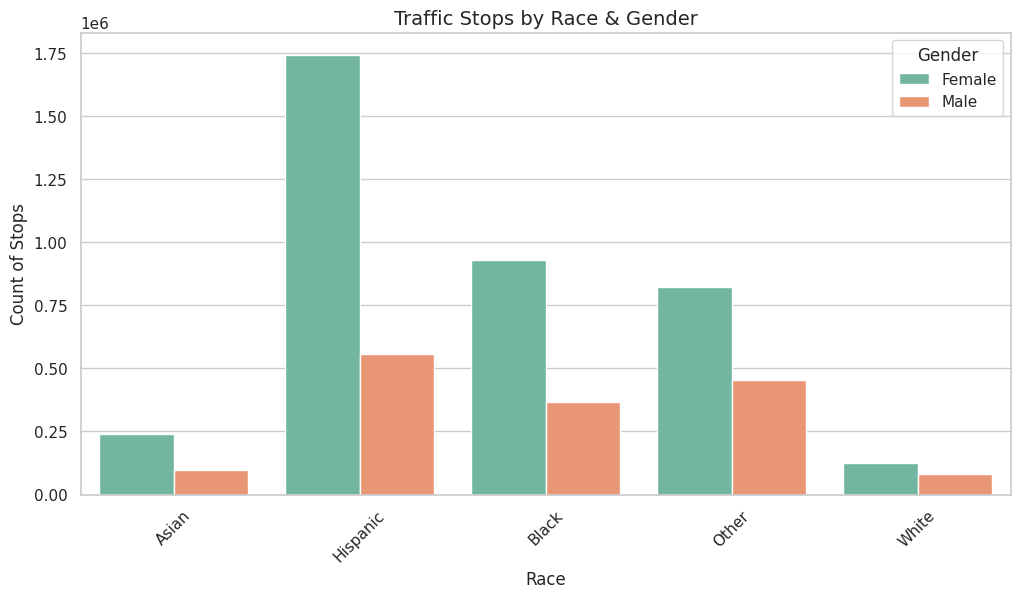

In [ ]:
# Define mappings for race and gender labels
race_mapping = {0: "White", 1: "Black", 2: "Hispanic", 3: "Asian", 4: "Other"}
gender_mapping = {0: "Male", 1: "Female"}

# Replace encoded values with actual labels
df["subject_race_label"] = df["subject_race_encoded"].replace(race_mapping)
df["subject_sex_label"] = df["subject_sex_encoded"].replace(gender_mapping)

# Plot with labels
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="subject_race_label", hue="subject_sex_label", palette="Set2")
plt.title("Traffic Stops by Race & Gender", fontsize=14)
plt.xlabel("Race")
plt.ylabel("Count of Stops")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.show()

**Traffic Stop Rate by District & Region**

<Figure size 1800x1200 with 0 Axes>

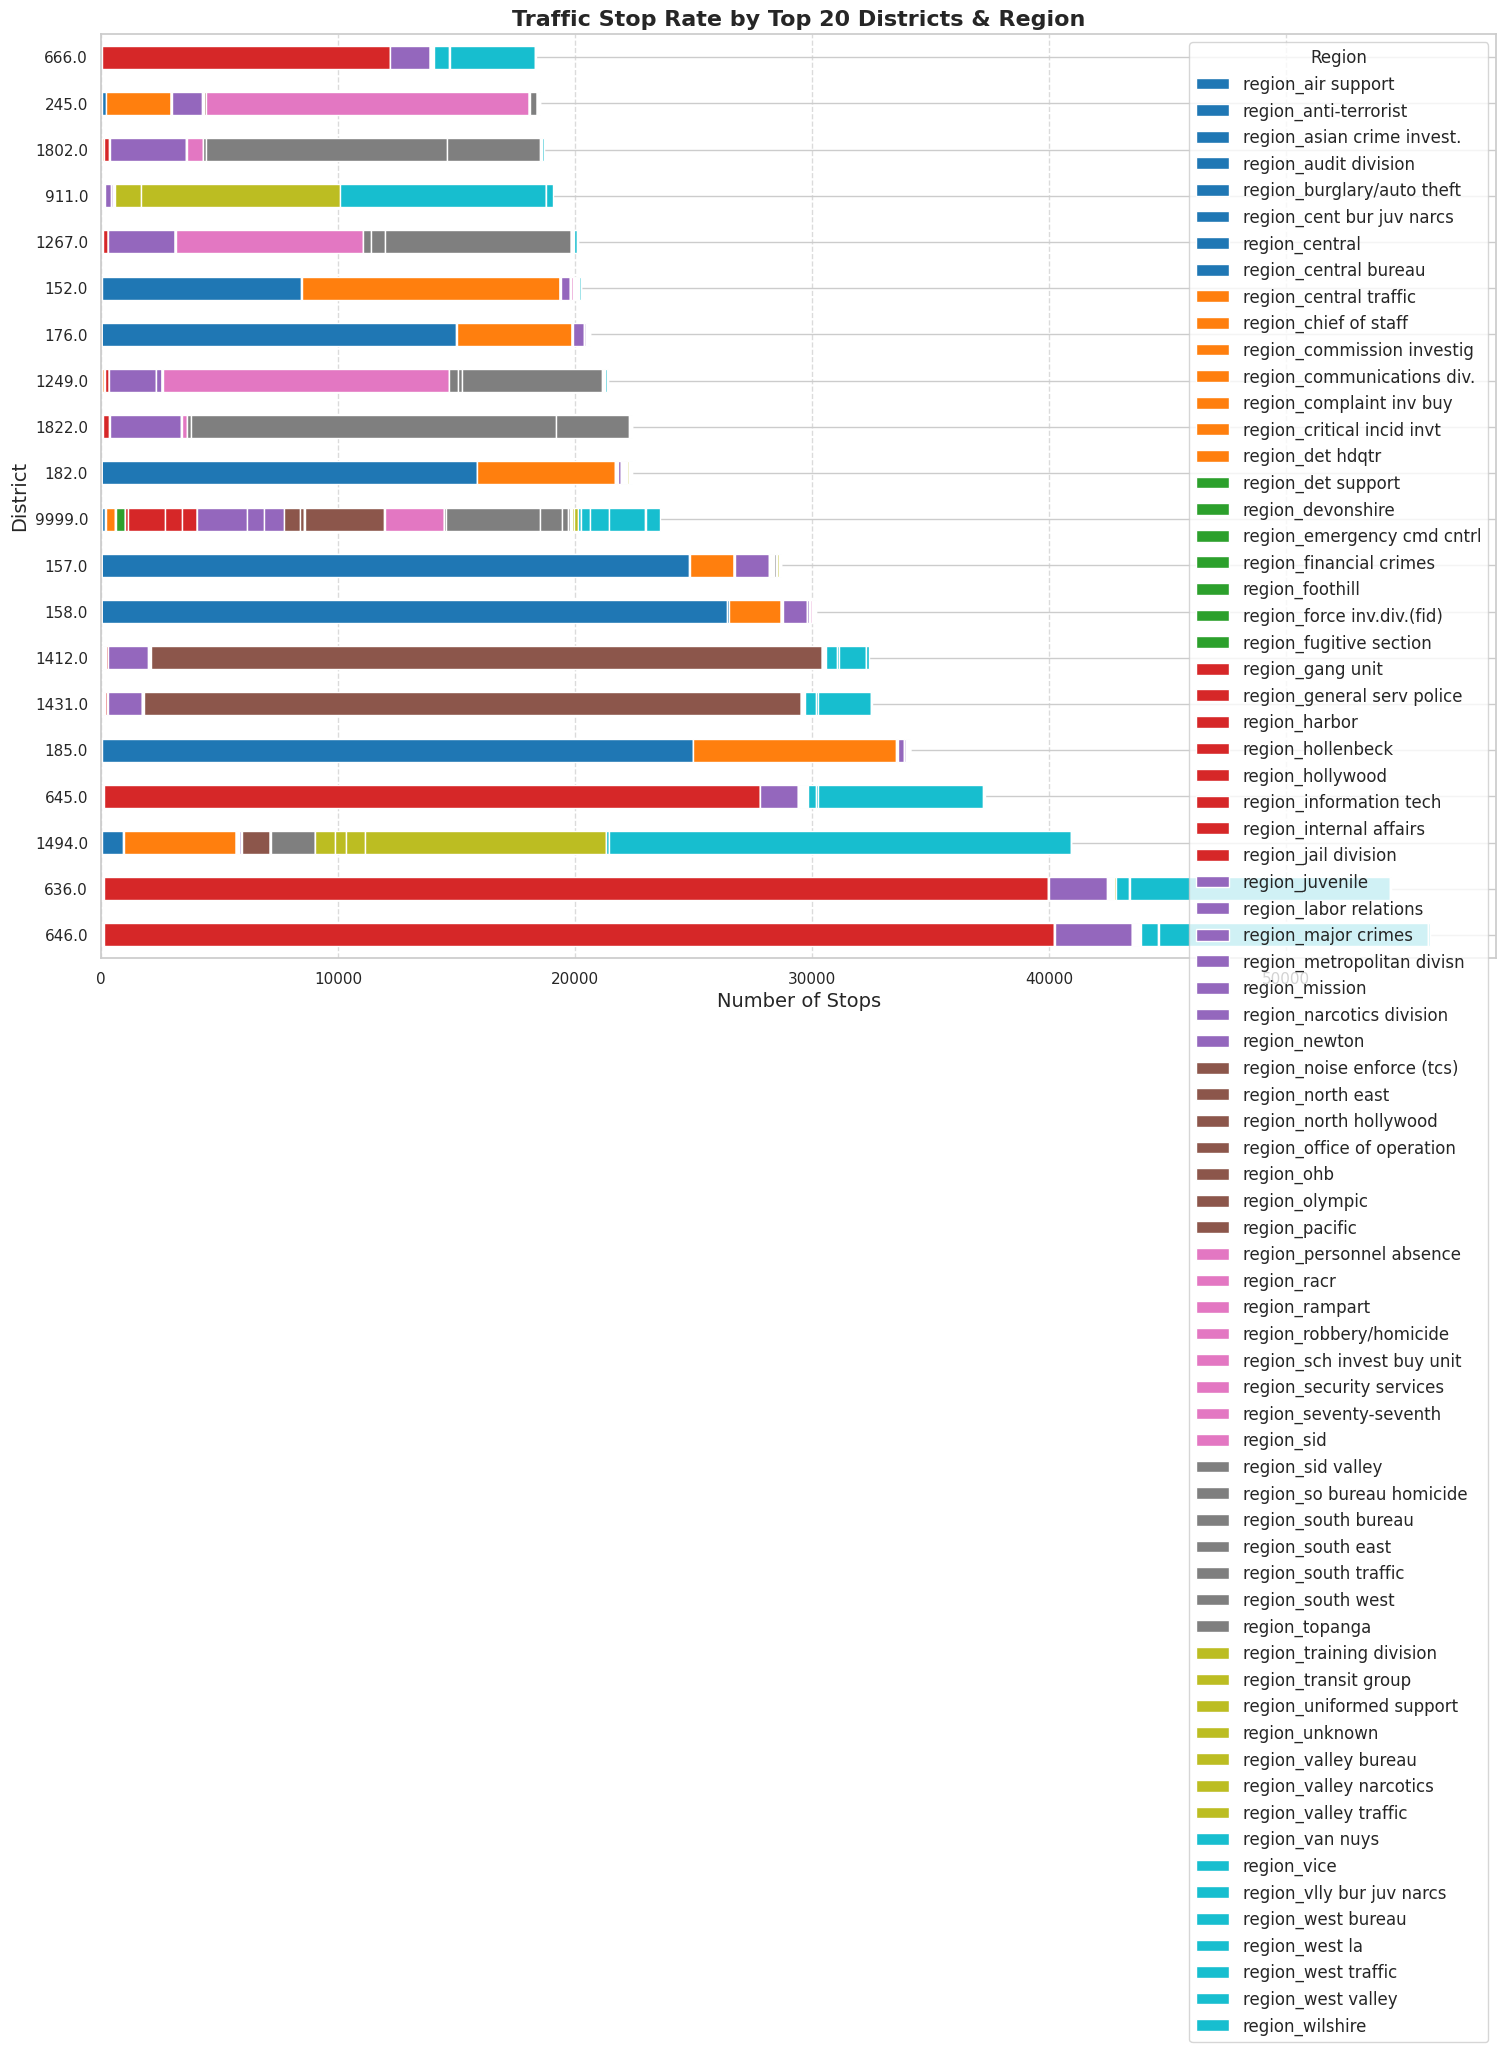

In [ ]:
import matplotlib.pyplot as plt

# ✅ Select region columns dynamically
region_columns = [col for col in df.columns if col.startswith('region_')]

# ✅ Create a new column for the region by combining the existing ones
df['region'] = df[region_columns].idxmax(axis=1)  # Get the name of the column with the highest value for each row

# ✅ Group by district and the newly created region column
district_region_counts = df.groupby(['district', 'region']).size().unstack(fill_value=0)

# ✅ Sort districts by total stops and keep only top 20
top_districts = district_region_counts.sum(axis=1).sort_values(ascending=False).head(20)
district_region_counts = district_region_counts.loc[top_districts.index]

# ✅ Plot the graph
plt.figure(figsize=(18, 12))
district_region_counts.plot(kind="barh", stacked=True, colormap="tab10", figsize=(18, 12))

# ✅ Customize the plot
plt.title("Traffic Stop Rate by Top 20 Districts & Region", fontsize=16, fontweight='bold')
plt.xlabel("Number of Stops", fontsize=14)
plt.ylabel("District", fontsize=14)
plt.legend(title="Region", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# ✅ Show the plot
plt.show()

**Violation Type Analysis (Pedestrian vs. Vehicular)**

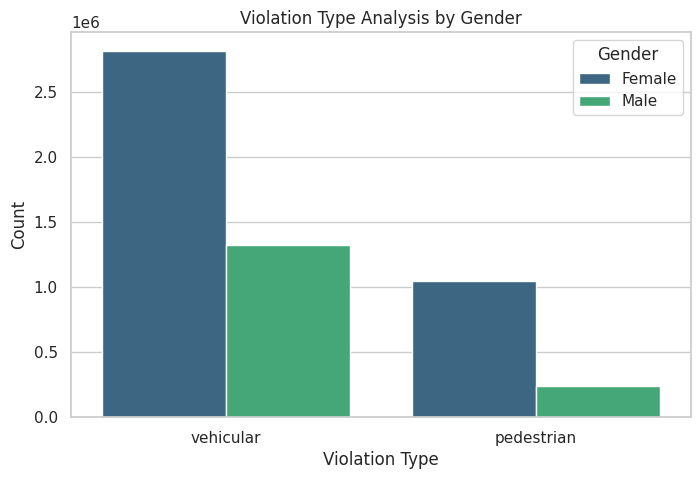

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="type", hue="subject_sex", palette="viridis")

plt.title("Violation Type Analysis by Gender")
plt.xlabel("Violation Type")
plt.ylabel("Count")
plt.legend(title="Gender", labels=["Female", "Male"])  # Explicitly setting labels

plt.show()

**Temporal Analysis (Bias Patterns Based on Time & Year)- If certain years saw spikes in stops, it might correlate with policy changes or events**

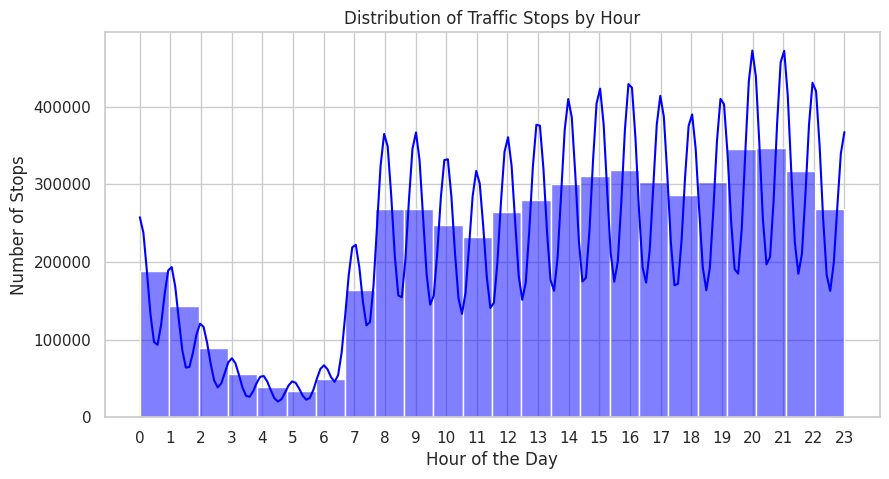

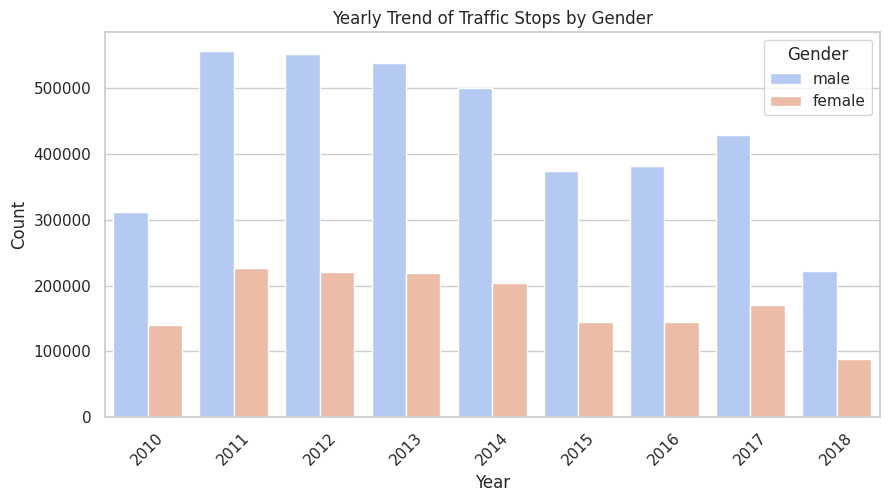

In [ ]:
# Stops by Hour of the Day
plt.figure(figsize=(10, 5))
sns.histplot(df['hour'], bins=24, kde=True, color="blue")
plt.title("Distribution of Traffic Stops by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Stops")
plt.xticks(range(0, 24))
plt.show()

# Stops Over the Years

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="year", hue="subject_sex", palette="coolwarm")
plt.title("Yearly Trend of Traffic Stops by Gender")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.show()


**Are Minority Groups Stopped More at Night?**

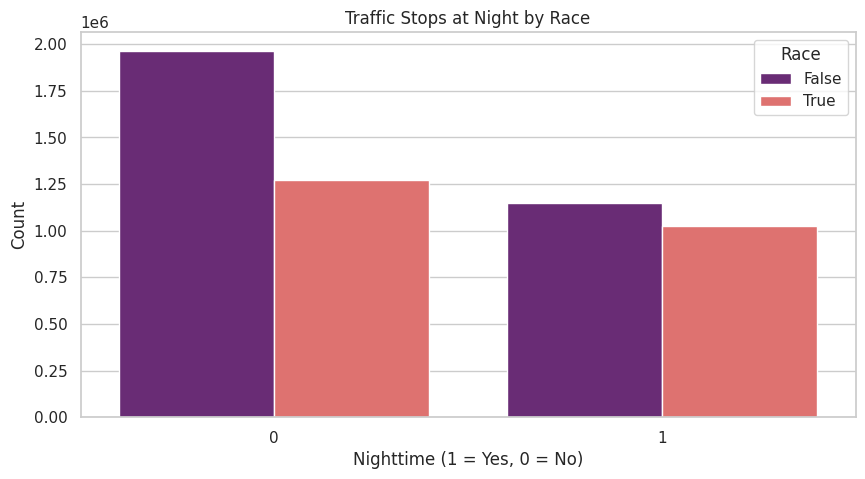

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="is_night", hue="raw_descent_description_hispanic", palette="magma")
plt.title("Traffic Stops at Night by Race")
plt.xlabel("Nighttime (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.legend(title="Race")
plt.show()

**Step 3: Bias Detection with Fairness Metrics**

**Bias Mitigation Technique- Using Adversarial Debiasing and Reweighting as these will give both direct debiasing during training and data balancing techniques. Fairness Metrics- using Demographic Parity, and Disparate Impact. These metrics cover different aspects of fairness: Demographic Parity for overall group fairness, Disparate Impact for identifying any unintended adverse impacts.**

In [ ]:
# Get unique values for race and sex
distinct_races = df['subject_race'].unique()
distinct_sexes = df['subject_sex'].unique()
distinct_offences= df['type'].unique()

print("Distinct subject races:", distinct_races)
print("Distinct subject sexes:", distinct_sexes)
print("Distinct subject offences:", distinct_offences)

Distinct subject races: ['other' 'hispanic' 'black' 'white' 'asian/pacific islander']
Distinct subject sexes: ['male' 'female']
Distinct subject offences: ['vehicular' 'pedestrian']


In [ ]:
df.head()

,raw_row_number,date,time,district,subject_race,subject_sex,officer_id_hash,type,year,month,...,region_west bureau,region_west la,region_west traffic,region_west valley,region_wilshire,raw_descent_description_asian,raw_descent_description_black,raw_descent_description_hispanic,raw_descent_description_other,raw_descent_description_white
1,240731.0,2010-01-01,00:05:00,665.0,other,male,b707de41e0,vehicular,2010,1,...,False,False,True,False,False,False,False,False,True,False
2,3187015.5,2010-01-01,00:10:00,1258.0,hispanic,male,b49ae7078c,pedestrian,2010,1,...,False,False,False,False,False,False,False,True,False,False
3,241116.0,2010-01-01,00:10:00,1635.0,hispanic,male,e70ce46248,vehicular,2010,1,...,False,False,False,False,False,False,False,True,False,False
4,240681.0,2010-01-01,00:15:00,882.0,other,male,8587bd743c,vehicular,2010,1,...,False,True,False,False,False,False,False,False,True,False
5,240602.0,2010-01-01,00:20:00,559.0,hispanic,male,601bf1fdff,vehicular,2010,1,...,False,False,False,False,False,False,False,True,False,False


Overall vehicular ticket probability: 0.7632055151346366

Probability by subject race:
 subject_race
asian/pacific islander    0.912308
black                     0.678953
hispanic                  0.752602
other                     0.901681
white                     0.807409
Name: positive_outcome, dtype: float64

Demographic parity difference by race:
 subject_race
asian/pacific islander    0.149103
black                    -0.084252
hispanic                 -0.010604
other                     0.138476
white                     0.044204
Name: positive_outcome, dtype: float64

Demographic parity ratio by race:
 subject_race
asian/pacific islander    1.195364
black                     0.889607
hispanic                  0.986106
other                     1.181440
white                     1.057918
Name: positive_outcome, dtype: float64

Probability by subject sex:
 subject_sex
female    0.847275
male      0.729301
Name: positive_outcome, dtype: float64

Demographic parity difference by s

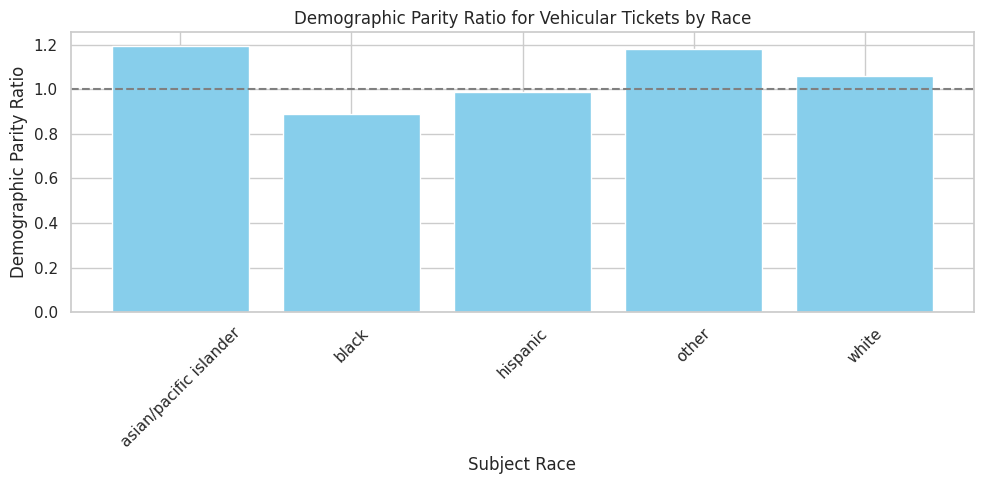

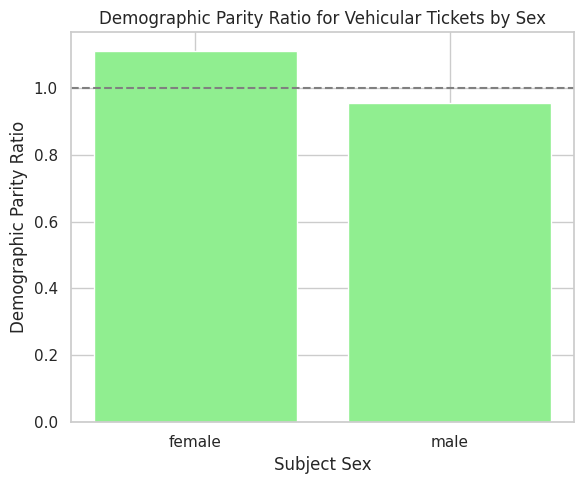

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is already loaded as df
# Define the binary outcome for vehicular tickets:
# 1 indicates a vehicular ticket; 0 otherwise.
df['positive_outcome'] = (df['type'] == 'vehicular').astype(int)

# Calculate overall probability of a vehicular ticket
overall_prob = df['positive_outcome'].mean()

# -------------------------
# Demographic parity analysis for subject race (vehicular)
# -------------------------
race_prob = df.groupby('subject_race')['positive_outcome'].mean()
race_parity_diff = race_prob - overall_prob
race_parity_ratio = race_prob / overall_prob

print("Overall vehicular ticket probability:", overall_prob)
print("\nProbability by subject race:\n", race_prob)
print("\nDemographic parity difference by race:\n", race_parity_diff)
print("\nDemographic parity ratio by race:\n", race_parity_ratio)

# -------------------------
# Demographic parity analysis for subject sex (vehicular)
# -------------------------
sex_prob = df.groupby('subject_sex')['positive_outcome'].mean()
sex_parity_diff = sex_prob - overall_prob
sex_parity_ratio = sex_prob / overall_prob

print("\nProbability by subject sex:\n", sex_prob)
print("\nDemographic parity difference by sex:\n", sex_parity_diff)
print("\nDemographic parity ratio by sex:\n", sex_parity_ratio)

# -------------------------
# Plotting the results for vehicular tickets
# -------------------------

# Plotting demographic parity ratio for race
plt.figure(figsize=(10, 5))
plt.bar(race_prob.index, race_parity_ratio, color='skyblue')
plt.axhline(1, color='gray', linestyle='--')  # reference line at 1 for parity
plt.xlabel('Subject Race')
plt.ylabel('Demographic Parity Ratio')
plt.title('Demographic Parity Ratio for Vehicular Tickets by Race')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting demographic parity ratio for sex
plt.figure(figsize=(6, 5))
plt.bar(sex_prob.index, sex_parity_ratio, color='lightgreen')
plt.axhline(1, color='gray', linestyle='--')  # reference line at 1 for parity
plt.xlabel('Subject Sex')
plt.ylabel('Demographic Parity Ratio')
plt.title('Demographic Parity Ratio for Vehicular Tickets by Sex')
plt.tight_layout()
plt.show()


Overall pedestrian ticket probability: 0.23679448486536336

Probability by subject race:
 subject_race
asian/pacific islander    0.087692
black                     0.321047
hispanic                  0.247398
other                     0.098319
white                     0.192591
Name: positive_outcome, dtype: float64

Demographic parity difference by race:
 subject_race
asian/pacific islander   -0.149103
black                     0.084252
hispanic                  0.010604
other                    -0.138476
white                    -0.044204
Name: positive_outcome, dtype: float64

Demographic parity ratio by race:
 subject_race
asian/pacific islander    0.370328
black                     1.355803
hispanic                  1.044781
other                     0.415207
white                     0.813325
Name: positive_outcome, dtype: float64

Probability by subject sex:
 subject_sex
female    0.152725
male      0.270699
Name: positive_outcome, dtype: float64

Demographic parity difference by

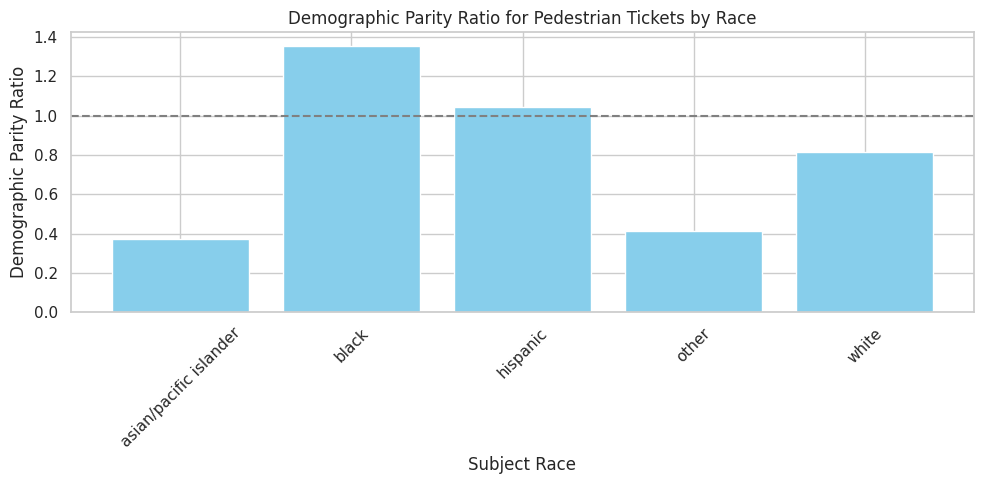

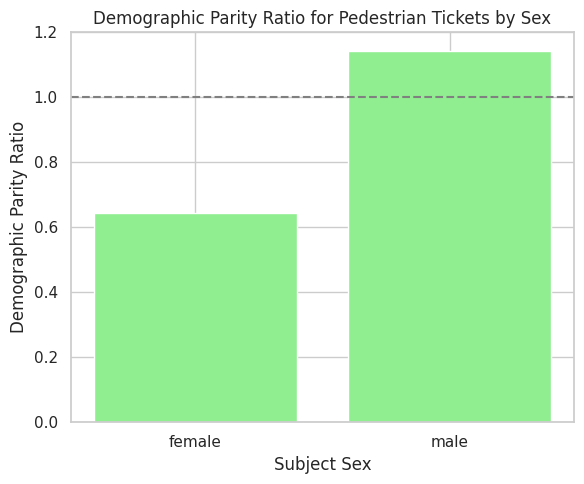

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Define the binary outcome for pedestrian tickets:
# 1 indicates a pedestrian ticket; 0 otherwise.
df['positive_outcome'] = (df['type'] == 'pedestrian').astype(int)

# Calculate overall probability of a pedestrian ticket
overall_prob = df['positive_outcome'].mean()

# -------------------------
# Demographic parity analysis for subject race
# -------------------------
race_prob = df.groupby('subject_race')['positive_outcome'].mean()
race_parity_diff = race_prob - overall_prob
race_parity_ratio = race_prob / overall_prob

print("Overall pedestrian ticket probability:", overall_prob)
print("\nProbability by subject race:\n", race_prob)
print("\nDemographic parity difference by race:\n", race_parity_diff)
print("\nDemographic parity ratio by race:\n", race_parity_ratio)

# -------------------------
# Demographic parity analysis for subject sex
# -------------------------
sex_prob = df.groupby('subject_sex')['positive_outcome'].mean()
sex_parity_diff = sex_prob - overall_prob
sex_parity_ratio = sex_prob / overall_prob

print("\nProbability by subject sex:\n", sex_prob)
print("\nDemographic parity difference by sex:\n", sex_parity_diff)
print("\nDemographic parity ratio by sex:\n", sex_parity_ratio)

# -------------------------
# Plotting the results
# -------------------------
# Plotting demographic parity ratio for race
plt.figure(figsize=(10, 5))
plt.bar(race_prob.index, race_parity_ratio, color='skyblue')
plt.axhline(1, color='gray', linestyle='--')  # reference line at 1 for parity
plt.xlabel('Subject Race')
plt.ylabel('Demographic Parity Ratio')
plt.title('Demographic Parity Ratio for Pedestrian Tickets by Race')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting demographic parity ratio for sex
plt.figure(figsize=(6, 5))
plt.bar(sex_prob.index, sex_parity_ratio, color='lightgreen')
plt.axhline(1, color='gray', linestyle='--')  # reference line at 1 for parity
plt.xlabel('Subject Sex')
plt.ylabel('Demographic Parity Ratio')
plt.title('Demographic Parity Ratio for Pedestrian Tickets by Sex')
plt.tight_layout()
plt.show()


Pedestrian Tickets Analysis:
Overall pedestrian ticket probability: 0.23679448486536336

Probability by subject race:
subject_race
asian/pacific islander    0.087692
black                     0.321047
hispanic                  0.247398
other                     0.098319
white                     0.192591
Name: positive_outcome, dtype: float64

Demographic parity difference by race:
subject_race
asian/pacific islander   -0.149103
black                     0.084252
hispanic                  0.010604
other                    -0.138476
white                    -0.044204
Name: positive_outcome, dtype: float64

Demographic parity ratio by race:
subject_race
asian/pacific islander    0.370328
black                     1.355803
hispanic                  1.044781
other                     0.415207
white                     0.813325
Name: positive_outcome, dtype: float64

Probability by subject sex:
subject_sex
female    0.152725
male      0.270699
Name: positive_outcome, dtype: float64

Demogra

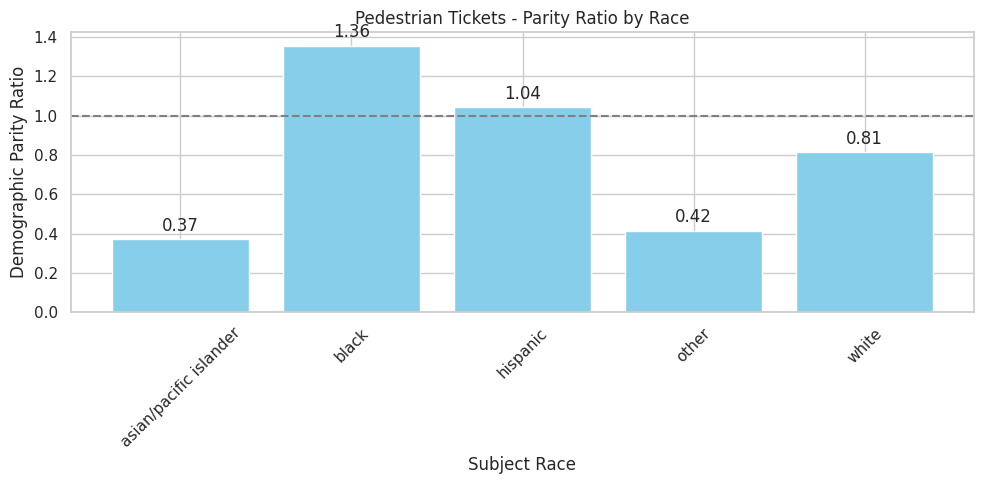

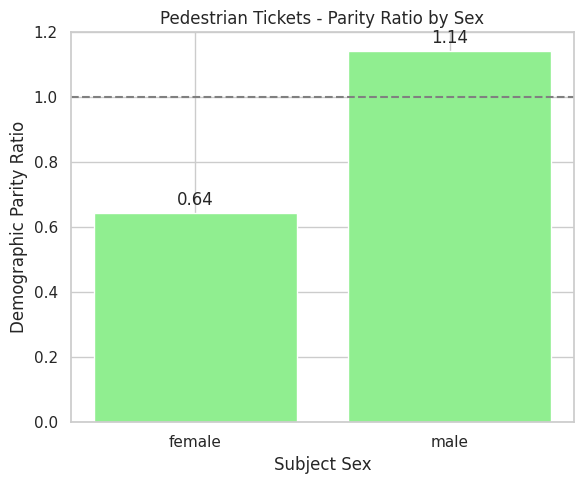


Vehicular Tickets Analysis:
Overall vehicular ticket probability: 0.7632055151346366

Probability by subject race:
subject_race
asian/pacific islander    0.912308
black                     0.678953
hispanic                  0.752602
other                     0.901681
white                     0.807409
Name: positive_outcome, dtype: float64

Demographic parity difference by race:
subject_race
asian/pacific islander    0.149103
black                    -0.084252
hispanic                 -0.010604
other                     0.138476
white                     0.044204
Name: positive_outcome, dtype: float64

Demographic parity ratio by race:
subject_race
asian/pacific islander    1.195364
black                     0.889607
hispanic                  0.986106
other                     1.181440
white                     1.057918
Name: positive_outcome, dtype: float64

Probability by subject sex:
subject_sex
female    0.847275
male      0.729301
Name: positive_outcome, dtype: float64

Demograph

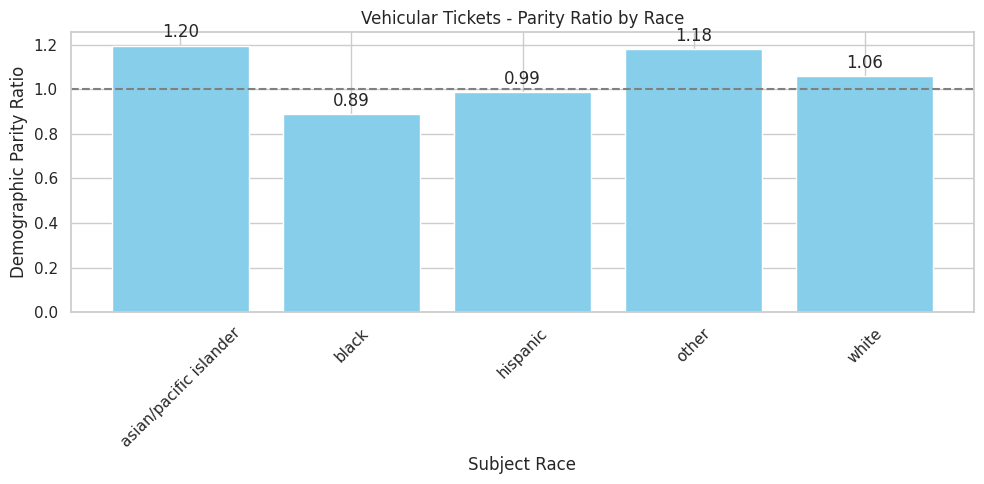

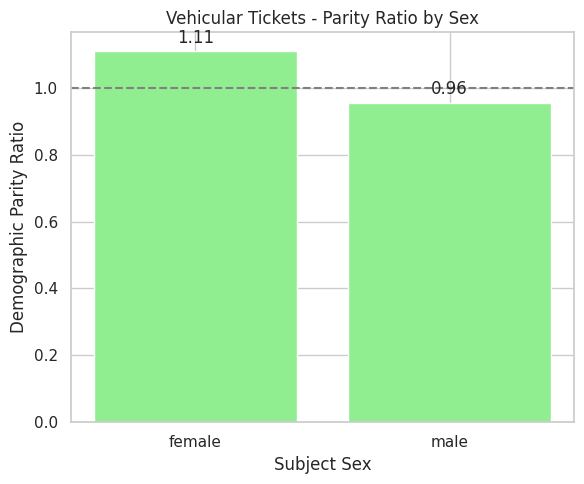

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is already loaded as df
# For example: df = pd.read_csv('your_ticket_data.csv')

############################################
# Analysis & Plot for Pedestrian Tickets
############################################

# Define the binary outcome for pedestrian tickets:
# 1 indicates a pedestrian ticket; 0 otherwise.
df['positive_outcome'] = (df['type'] == 'pedestrian').astype(int)

# Calculate overall probability of a pedestrian ticket
overall_prob_ped = df['positive_outcome'].mean()

# -------------------------
# Demographic parity analysis for subject race (pedestrian)
# -------------------------
race_prob_ped = df.groupby('subject_race')['positive_outcome'].mean()
race_parity_diff_ped = race_prob_ped - overall_prob_ped
race_parity_ratio_ped = race_prob_ped / overall_prob_ped

print("Pedestrian Tickets Analysis:")
print("Overall pedestrian ticket probability:", overall_prob_ped)
print("\nProbability by subject race:")
print(race_prob_ped)
print("\nDemographic parity difference by race:")
print(race_parity_diff_ped)
print("\nDemographic parity ratio by race:")
print(race_parity_ratio_ped)

# -------------------------
# Demographic parity analysis for subject sex (pedestrian)
# -------------------------
sex_prob_ped = df.groupby('subject_sex')['positive_outcome'].mean()
sex_parity_diff_ped = sex_prob_ped - overall_prob_ped
sex_parity_ratio_ped = sex_prob_ped / overall_prob_ped

print("\nProbability by subject sex:")
print(sex_prob_ped)
print("\nDemographic parity difference by sex:")
print(sex_parity_diff_ped)
print("\nDemographic parity ratio by sex:")
print(sex_parity_ratio_ped)

# -------------------------
# Plotting results for Pedestrian Tickets
# -------------------------
# Plot for subject race
plt.figure(figsize=(10, 5))
bars = plt.bar(race_prob_ped.index, race_parity_ratio_ped, color='skyblue')
plt.axhline(1, color='gray', linestyle='--')  # parity reference line
plt.xlabel('Subject Race')
plt.ylabel('Demographic Parity Ratio')
plt.title('Pedestrian Tickets - Parity Ratio by Race')
plt.xticks(rotation=45)
# Annotate bars with the ratio value
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Plot for subject sex
plt.figure(figsize=(6, 5))
bars = plt.bar(sex_prob_ped.index, sex_parity_ratio_ped, color='lightgreen')
plt.axhline(1, color='gray', linestyle='--')  # parity reference line
plt.xlabel('Subject Sex')
plt.ylabel('Demographic Parity Ratio')
plt.title('Pedestrian Tickets - Parity Ratio by Sex')
# Annotate bars with the ratio value
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()

############################################
# Analysis & Plot for Vehicular Tickets
############################################

# Define the binary outcome for vehicular tickets:
# 1 indicates a vehicular ticket; 0 otherwise.
df['positive_outcome'] = (df['type'] == 'vehicular').astype(int)

# Calculate overall probability of a vehicular ticket
overall_prob_veh = df['positive_outcome'].mean()

# -------------------------
# Demographic parity analysis for subject race (vehicular)
# -------------------------
race_prob_veh = df.groupby('subject_race')['positive_outcome'].mean()
race_parity_diff_veh = race_prob_veh - overall_prob_veh
race_parity_ratio_veh = race_prob_veh / overall_prob_veh

print("\nVehicular Tickets Analysis:")
print("Overall vehicular ticket probability:", overall_prob_veh)
print("\nProbability by subject race:")
print(race_prob_veh)
print("\nDemographic parity difference by race:")
print(race_parity_diff_veh)
print("\nDemographic parity ratio by race:")
print(race_parity_ratio_veh)

# -------------------------
# Demographic parity analysis for subject sex (vehicular)
# -------------------------
sex_prob_veh = df.groupby('subject_sex')['positive_outcome'].mean()
sex_parity_diff_veh = sex_prob_veh - overall_prob_veh
sex_parity_ratio_veh = sex_prob_veh / overall_prob_veh

print("\nProbability by subject sex:")
print(sex_prob_veh)
print("\nDemographic parity difference by sex:")
print(sex_parity_diff_veh)
print("\nDemographic parity ratio by sex:")
print(sex_parity_ratio_veh)

# -------------------------
# Plotting results for Vehicular Tickets
# -------------------------
# Plot for subject race
plt.figure(figsize=(10, 5))
bars = plt.bar(race_prob_veh.index, race_parity_ratio_veh, color='skyblue')
plt.axhline(1, color='gray', linestyle='--')  # parity reference line
plt.xlabel('Subject Race')
plt.ylabel('Demographic Parity Ratio')
plt.title('Vehicular Tickets - Parity Ratio by Race')
plt.xticks(rotation=45)
# Annotate bars with the ratio value
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Plot for subject sex
plt.figure(figsize=(6, 5))
bars = plt.bar(sex_prob_veh.index, sex_parity_ratio_veh, color='lightgreen')
plt.axhline(1, color='gray', linestyle='--')  # parity reference line
plt.xlabel('Subject Sex')
plt.ylabel('Demographic Parity Ratio')
plt.title('Vehicular Tickets - Parity Ratio by Sex')
# Annotate bars with the ratio value
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
#Rewighting
#Vehicular

# Assuming df is your DataFrame with a column 'type'
# For vehicular tickets, define positive_outcome as:
df['positive_outcome'] = (df['type'] == 'vehicular').astype(int)

# Total number of samples
n = len(df)

# Calculate overall probability of each outcome (P(Y=y)):
p_y = df['positive_outcome'].value_counts(normalize=True)

# Calculate overall probability for each group (P(G=g)) using subject_race:
p_g = df['subject_race'].value_counts(normalize=True)

# Calculate joint probabilities P(G=g, Y=y) for each combination of subject_race and positive_outcome:
joint_counts = df.groupby(['subject_race', 'positive_outcome']).size()
p_g_y = joint_counts / n

# Compute reweighting factors:
# weight(g, y) = (P(G=g) * P(Y=y)) / P(G=g, Y=y)
weights = {}
for group in p_g.index:
    for outcome in [0, 1]:
        # Ensure we have a non-zero joint probability
        if (group, outcome) in p_g_y and p_g_y[(group, outcome)] > 0:
            weights[(group, outcome)] = (p_g[group] * p_y[outcome]) / p_g_y[(group, outcome)]
        else:
            # If the combination doesn't exist, assign a default weight (or handle as appropriate)
            weights[(group, outcome)] = 0.0

# Apply the weights to each row in the DataFrame
df['sample_weight'] = df.apply(lambda row: weights[(row['subject_race'], row['positive_outcome'])], axis=1)

# Print out the reweighting factors
print("Reweighting factors (by subject_race and positive_outcome) for vehicular tickets:")
print(pd.DataFrame.from_dict(weights, orient='index', columns=['weight']))

# Optionally, inspect a sample of the DataFrame with the new sample weights
print("\nSample of DataFrame with new sample weights:")
print(df[['subject_race', 'positive_outcome', 'sample_weight']].head())


Reweighting factors (by subject_race and positive_outcome) for vehicular tickets:
                               weight
(hispanic, 0)                0.957138
(hispanic, 1)                1.014090
(black, 0)                   0.737570
(black, 1)                   1.124091
(white, 0)                   1.229521
(white, 1)                   0.945252
(other, 0)                   2.408440
(other, 1)                   0.846425
(asian/pacific islander, 0)  2.700306
(asian/pacific islander, 1)  0.836565

Sample of DataFrame with new sample weights:
  subject_race  positive_outcome  sample_weight
0        other                 1       0.846425
1     hispanic                 0       0.957138
2     hispanic                 1       1.014090
3        other                 1       0.846425
4     hispanic                 1       1.014090


In [ ]:
#Pedestrian

# Assuming df is your DataFrame and you already have the 'positive_outcome' column defined.
# For pedestrian tickets, positive_outcome is set as:
#   1 if the ticket is a pedestrian ticket, 0 otherwise.
# (If you've run the earlier block, this column is already defined.)

# Total number of samples
n = len(df)

# Calculate overall probabilities:
p_y = df['positive_outcome'].value_counts(normalize=True)  # P(Y=y)
p_g = df['subject_race'].value_counts(normalize=True)        # P(G=g)

# Calculate joint probabilities for each combination of subject_race and positive_outcome:
joint_counts = df.groupby(['subject_race', 'positive_outcome']).size()
p_g_y = joint_counts / n  # P(G=g, Y=y)

# Compute reweighting factors using the formula:
# weight(g, y) = (P(G=g) * P(Y=y)) / P(G=g, Y=y)
weights = {}
for group in p_g.index:
    for outcome in [0, 1]:
        if (group, outcome) in p_g_y and p_g_y[(group, outcome)] > 0:
            weights[(group, outcome)] = (p_g[group] * p_y[outcome]) / p_g_y[(group, outcome)]
        else:
            # If a combination doesn't exist, assign a default weight (or handle appropriately)
            weights[(group, outcome)] = 0.0

# Apply the weights to each row in the DataFrame
df['sample_weight'] = df.apply(lambda row: weights[(row['subject_race'], row['positive_outcome'])], axis=1)

# Check the sample weights distribution by group and outcome
print("Reweighting factors (by subject_race and positive_outcome):")
print(pd.DataFrame.from_dict(weights, orient='index', columns=['weight']))

# Optionally, inspect the new weights in the DataFrame
print("\nSample of DataFrame with new sample weights:")
print(df[['subject_race', 'positive_outcome', 'sample_weight']].head())


Reweighting factors (by subject_race and positive_outcome):
                               weight
(hispanic, 0)                0.957138
(hispanic, 1)                1.014090
(black, 0)                   0.737570
(black, 1)                   1.124091
(white, 0)                   1.229521
(white, 1)                   0.945252
(other, 0)                   2.408440
(other, 1)                   0.846425
(asian/pacific islander, 0)  2.700306
(asian/pacific islander, 1)  0.836565

Sample of DataFrame with new sample weights:
  subject_race  positive_outcome  sample_weight
0        other                 1       0.846425
1     hispanic                 0       0.957138
2     hispanic                 1       1.014090
3        other                 1       0.846425
4     hispanic                 1       1.014090
